-----------------------------------------------------
# Tech Challenge (Fase 1): Análise de Câncer de Pele
-----------------------------------------------------
Aluno: RM-366142 [Fernando Stuque Alves]

---

# Tech Challenge: 👁️ Modelo de Classificação de Imagens: Visão Computacional - Análise de Câncer de Pele

## Visão Geral

Este notebook detalha a construção de um classificador de imagens para o dataset HAM10000. O pipeline completo de Visão Computacional implementado aqui inclui as seguintes etapas:

*   **Pré-processamento de Imagens:**
    *   Criação de geradores de dados (`ImageDataGenerator`) para carregar e transformar imagens eficientemente.
    *   Aplicação de **Data Augmentation** no conjunto de treino para aumentar a diversidade dos dados.
    *   Normalização dos valores de pixel para o intervalo [0, 1].

*   **Arquitetura do Modelo (Transfer Learning):**
    *   Utilização da arquitetura **ResNet50V2** como extrator de features base.
    *   Implementação de uma estratégia de **fine-tuning**, descongelando as camadas superiores do modelo base para adaptação à tarefa específica.
    *   Adição de um cabeçalho de classificação customizado com `GlobalAveragePooling2D`, `Dense` e `Dropout`.

*   **Treinamento e Otimização:**
    *   Compilação do modelo com o otimizador `Adam`.
    *   Uso de `class_weight` para mitigar o efeito do desbalanceamento de classes na função de perda `categorical_crossentropy`.
    *   Emprego de callbacks inteligentes como `ReduceLROnPlateau` para ajuste dinâmico da taxa de aprendizado e `EarlyStopping` para prevenir o overfitting.

*   **Avaliação de Performance:**
    *   Análise do histórico de treinamento (acurácia e perda).
    *   Cálculo de métricas de classificação (`Accuracy`, `Balanced Accuracy`, `AUC`) no conjunto de teste.
    *   Visualização da Matriz de Confusão e do Relatório de Classificação detalhado.

**Instalando dependências**

In [1]:
!pip install -q tensorflow==2.15.0
print("\nInstalação concluída. Reinicie a sessão e execute tudo novamente.")


Instalação concluída. Reinicie a sessão e execute tudo novamente.


**Montando o ambiente**

In [2]:
from google.colab import drive
import os
import sys
import pandas as pd
import numpy as np
import os
import sys
import time
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 1. Montar o Google Drive
drive.mount('/content/drive')

# 2. Definir o caminho raiz do projeto
# ❗ É necessário ser o mesmo caminho que você usou no notebook '01_Setup_e_Processamento'
PROJECT_PATH = '/content/drive/MyDrive/Colab Notebooks/Tech Challenge/skin_cancer_analysis'

# 3. Mudar o diretório de trabalho para a raiz do projeto
os.chdir(PROJECT_PATH)

# 4. Adicionar o diretório raiz ao path do Python
if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)

# 5. Carregar nosso Data Frame com os metadados originais

METADATA_PATH = 'data/HAM10000_metadata.csv'
df_original = pd.read_csv(METADATA_PATH)

Mounted at /content/drive


**Por questão de performance, vamos copiar nossos dados do Google Drive para um disco local do Colab**

In [3]:
# --- Célula para otimizar o acesso aos dados ---
print("Iniciando a cópia dos dados de imagem do Google Drive para o disco local do Colab...")
print("Isso pode levar alguns minutos, mas acelerará o treinamento drasticamente.")

# Caminho de origem no seu Google Drive
gdrive_images_path = '/content/drive/MyDrive/Colab Notebooks/Tech Challenge/skin_cancer_analysis/data'

# Caminho de destino no disco local rápido do Colab
local_images_path = '/content/local_data'

start_time = time.time()
# Usamos 'ditto' ou 'rsync' se disponíveis, mas 'cp' é universal.
# A flag -R copia recursivamente, -n não sobrescreve se já existir.
!cp -R -n "{gdrive_images_path}" "{local_images_path}"
end_time = time.time()

print(f"\nCópia concluída em {end_time - start_time:.2f} segundos.")
print(f"Os dados agora estão em: {local_images_path}")

Iniciando a cópia dos dados de imagem do Google Drive para o disco local do Colab...
Isso pode levar alguns minutos, mas acelerará o treinamento drasticamente.

Cópia concluída em 636.50 segundos.
Os dados agora estão em: /content/local_data


## Visão Computacional

### Mapeamento de Imagens e Rótulos

As imagens estão em duas pastas: **data/ham10000_images_part_1** e **data/ham10000_images_part_2**. Precisamos criar um caminho completo para cada imagem.

Nosso plano agora é criar um dicionário para mapear o caminho e o **id** de cada arquivo de imagem através de uma nova coluna no Data Frame `df_original`.



In [7]:
df_original = pd.read_csv('data/HAM10000_metadata.csv')
base_skin_dir = '/content/local_data'

# Criar um dicionário com todos os caminhos de imagem
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}
df_original['path'] = df_original['image_id'].map(imageid_path_dict.get)
df_original.dropna(subset=['path'], inplace=True)

# Criar a coluna 'label' numérica para facilitar o cálculo dos pesos
df_original['label'] = pd.Categorical(df_original['dx']).codes

In [8]:
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/local_data/HAM10000_images_part_1/ISI...,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/local_data/HAM10000_images_part_1/ISI...,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/local_data/HAM10000_images_part_1/ISI...,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/local_data/HAM10000_images_part_1/ISI...,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/local_data/HAM10000_images_part_2/ISI...,2


### Treinamento, Teste e Validação

Assim como fizemos com os dados tabulares, vamos dividir o df_original em treino, validação e teste de forma estratificada pela coluna dx (ou label).

In [9]:
# Usaremos os mesmos dados de treino/val/teste
train_df, test_df = train_test_split(df_original, test_size=0.2, stratify=df_original['label'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

In [10]:
IMG_SIZE = 224 # ResNet funciona melhor com 224x224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True, # Adicionar flip vertical
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

### Gerenciando nossas imagens

Esta é a forma mais eficiente de alimentar as imagens para o modelo sem carregar todas na memória.

❗ Um ponto de atenção aqui é: aplique **Data Augmentation APENAS** no gerador de treino.

Utilizar esta técnica é recomendado quando não se tem um acervo de imagens muito grande, pois a partir da mesma imagem, cria-se uma variação dela com rotações, inversões, espelhamento, etc, o que ajuda a simular "novos" dados sem a necessidade de incluir mais imagens. Com isso, melhoramos a robustez e generalização do nosso modelo, e também previne o overfitting (sobreajsute).

### Carregando um modelo pré-treinado **ResNet50V2**

A escolha deste modelo foi baseado na sua arquitetura simples e eficiente que não exigem processamentos computacionais muito grandes.

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Gerador para o conjunto de TREINO com Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Gerador para VALIDAÇÃO e TESTE - Apenas normalização
val_test_datagen = ImageDataGenerator(rescale=1./255)

# --- 3. Criando os fluxos de dados a partir dos DataFrames ---

print("Criando gerador de treino...")
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='dx',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True  # Importante embaralhar os dados de treino
)

print("\nCriando gerador de validação...")
val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='dx',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Não embaralhe os dados de validação
)

print("\nCriando gerador de teste...")
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='dx',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE, # Pode usar um batch size de 1 se preferir para avaliação
    class_mode='categorical',
    shuffle=False  # NUNCA embaralhe os dados de teste
)

print("\nClasses encontradas pelo gerador de treino:")
print(train_generator.class_indices)

Criando gerador de treino...
Found 6409 validated image filenames belonging to 7 classes.

Criando gerador de validação...
Found 1603 validated image filenames belonging to 7 classes.

Criando gerador de teste...
Found 2003 validated image filenames belonging to 7 classes.

Classes encontradas pelo gerador de treino:
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [12]:
# Carregar o modelo base ResNet50V2
# include_top=False remove a camada final de classificação original.
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# **ESTRATÉGIA DE FINE-TUNING IMEDIATO**
# Em vez de congelar tudo, vamos congelar apenas a primeira metade do modelo.
# Isso permite que as camadas mais profundas (que detectam features complexas) comecem a se adaptar imediatamente.
base_model.trainable = True
fine_tune_at = int(len(base_model.layers) / 2) # Congelar a primeira metade

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print(f"Modelo base com {len(base_model.layers)} camadas. Congelando as primeiras {fine_tune_at} camadas.")

# Adicionar um cabeçalho de classificação mais robusto
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x) # Camada densa maior
x = BatchNormalization()(x) # Batch Normalization para estabilizar
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x) # 7 classes

model = Model(inputs=base_model.input, outputs=predictions)

# Compilar com um otimizador e taxa de aprendizado robustos
optimizer = Adam(learning_rate=1e-4) # Um bom ponto de partida para fine-tuning
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')] # Forma mais robusta de chamar AUC
)

model.summary()

# Calcular os pesos de classe
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))

94668760/94668760 [==============================] - 5s 0us/step
Modelo base com 190 camadas. Congelando as primeiras 95 camadas.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0    

In [13]:
print("\n--- Iniciando Treinamento e Fine-Tuning Unificado ---")

# Callbacks para um treinamento inteligente
checkpoint = ModelCheckpoint(
    'saved_models/cnn_resnet_best.h5',
    monitor='val_auc', # Monitorar a AUC de validação
    save_best_only=True,
    mode='max'
)
early_stop = EarlyStopping(
    monitor='val_auc',
    patience=10,
    mode='max',
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    mode='max'
)

# Treinar o modelo
history = model.fit(
    train_generator,
    epochs=50, # Um número alto de épocas, porém o EarlyStopping vai parar quando encontrar o melhor estágio
    validation_data=val_generator,
    class_weight=class_weight_dict,
    callbacks=[checkpoint, early_stop, reduce_lr]
)


--- Iniciando Treinamento e Fine-Tuning Unificado ---
Epoch 1/50
201/201 [==============================] - ETA: 0s - loss: 2.0859 - accuracy: 0.2849 - auc: 0.6438

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


201/201 [==============================] - 261s 1s/step - loss: 2.0859 - accuracy: 0.2849 - auc: 0.6438 - val_loss: 0.8769 - val_accuracy: 0.6943 - val_auc: 0.9386 - lr: 1.0000e-04
Epoch 2/50
201/201 [==============================] - 248s 1s/step - loss: 1.5446 - accuracy: 0.3494 - auc: 0.7055 - val_loss: 1.6758 - val_accuracy: 0.4866 - val_auc: 0.8029 - lr: 1.0000e-04
Epoch 3/50
201/201 [==============================] - 247s 1s/step - loss: 1.2576 - accuracy: 0.3988 - auc: 0.7460 - val_loss: 1.7573 - val_accuracy: 0.4791 - val_auc: 0.8123 - lr: 1.0000e-04
Epoch 4/50
201/201 [==============================] - 247s 1s/step - loss: 1.0529 - accuracy: 0.4402 - auc: 0.7796 - val_loss: 1.6557 - val_accuracy: 0.4704 - val_auc: 0.7952 - lr: 1.0000e-04
Epoch 5/50
201/201 [==============================] - 247s 1s/step - loss: 0.9145 - accuracy: 0.4845 - auc: 0.8102 - val_loss: 1.5154 - val_accuracy: 0.5240 - val_auc: 0.8352 - lr: 2.0000e-05
Epoch 6/50
201/201 [==============================]

Carregando o melhor modelo salvo...

--- Histórico de Treinamento ---


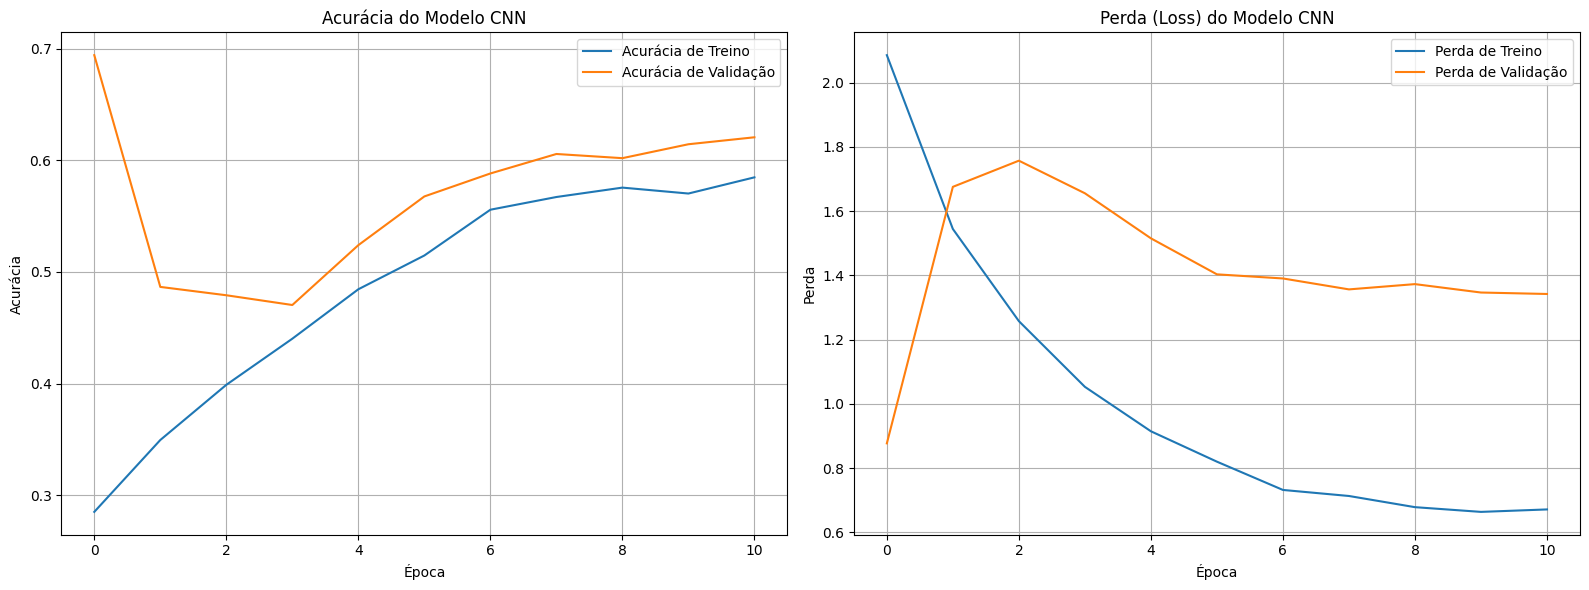


--- Avaliando o modelo no conjunto de teste... ---
63/63 [==============================] - 33s 505ms/step

--- Métricas Gerais do Modelo CNN (ResNet - Fine-Tuned) ---
Acurácia Geral: 0.6915
Acurácia Balanceada: 0.4829
AUC Ponderada (One-vs-One): 0.8837

--- Relatório de Classificação por Classe ---


,precision,recall,f1-score,support
akiec,0.360656,0.338462,0.349206,65.000000
bcc,0.320988,0.757282,0.450867,103.000000
bkl,0.440678,0.236364,0.307692,220.000000
df,0.400000,0.434783,0.416667,23.000000
mel,0.346863,0.421525,0.380567,223.000000
nv,0.885986,0.834452,0.859447,1341.000000
vasc,0.454545,0.357143,0.400000,28.000000
accuracy,0.691463,0.691463,0.691463,0.691463
macro avg,0.458531,0.482858,0.452064,2003.000000
weighted avg,0.719340,0.691463,0.696454,2003.000000



--- Matriz de Confusão ---


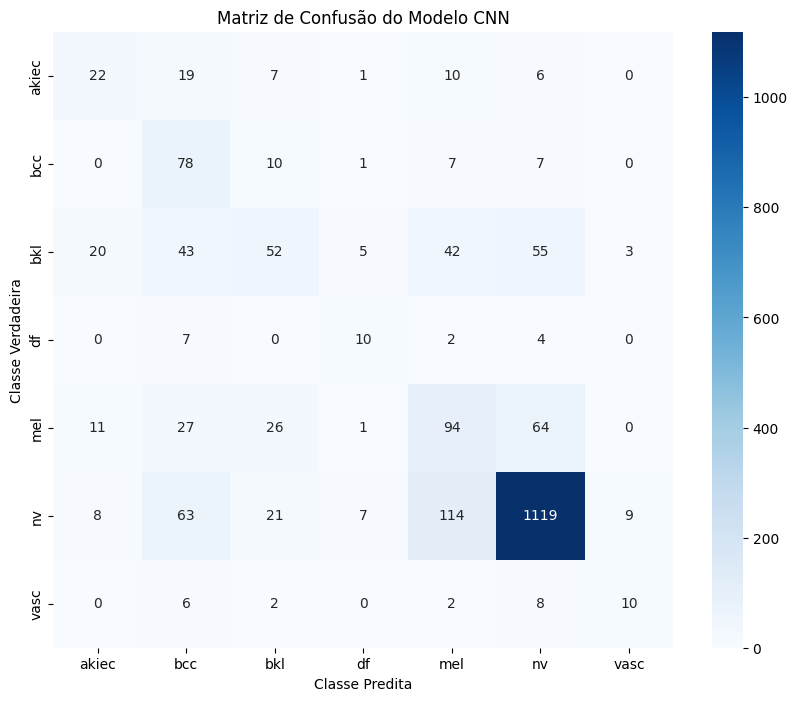

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score, roc_auc_score
from tensorflow.keras.models import load_model

# --- 1. Carregar o Melhor Modelo Salvo ---
print("Carregando o melhor modelo salvo...")
# O nome do arquivo deve ser o mesmo usado no seu ModelCheckpoint
best_model_cnn = load_model('saved_models/cnn_resnet_best.h5')


# --- 2. Visualizar o Histórico de Treinamento ---

def plot_training_history(history):
    # Extrair as métricas do objeto history
    # O nome da métrica de AUC pode variar a cada versão de TensorFlow
    # Ex: pode ser 'auc' ou 'AUC'. Vamos garantir pelas duas maneiras.
    acc_key = 'accuracy' if 'accuracy' in history.history else 'acc'
    val_acc_key = 'val_accuracy' if 'val_accuracy' in history.history else 'val_acc'
    auc_key = 'auc' if 'auc' in history.history else 'AUC'
    val_auc_key = 'val_auc' if 'val_auc' in history.history else 'val_AUC'

    acc = history.history[acc_key]
    val_acc = history.history[val_acc_key]
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(16, 6))

    # Gráfico da Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Acurácia de Treino')
    plt.plot(val_acc, label='Acurácia de Validação')
    plt.title('Acurácia do Modelo CNN')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.grid(True)

    # Gráfico da Perda (Loss)
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Perda de Treino')
    plt.plot(val_loss, label='Perda de Validação')
    plt.title('Perda (Loss) do Modelo CNN')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


print("\n--- Histórico de Treinamento ---")
plot_training_history(history)


# --- 3. Avaliação no Conjunto de Teste ---
print("\n--- Avaliando o modelo no conjunto de teste... ---")
test_generator.reset()

# Fazer as previsões
y_pred_proba = best_model_cnn.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)

# Obter os rótulos verdadeiros
y_true = test_generator.classes

# Obter os nomes das classes
class_names = list(test_generator.class_indices.keys())

# --- 4. Exibição das Métricas em Tabela ---
accuracy = accuracy_score(y_true, y_pred)
balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_pred_proba, multi_class='ovo', average='weighted')

print("\n--- Métricas Gerais do Modelo CNN (ResNet - Fine-Tuned) ---")
print(f"Acurácia Geral: {accuracy:.4f}")
print(f"Acurácia Balanceada: {balanced_accuracy:.4f}")
print(f"AUC Ponderada (One-vs-One): {auc_score:.4f}")

print("\n--- Relatório de Classificação por Classe ---")
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()
display(df_report.style.background_gradient(cmap='Greens', subset=['precision', 'recall', 'f1-score']))

# --- 5. Exibição Gráfica da Matriz de Confusão ---
print("\n--- Matriz de Confusão ---")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusão do Modelo CNN')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Predita')
plt.show()

### Performando um teste antes da análise final e subir o modelo em produção

Mapeamento de Classes: {0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}

--- Teste com Imagem Aleatória ---
Por favor, faça o upload de uma imagem de lesão de pele (JPG, PNG).


Saving lpele5.jpg to lpele5.jpg
1/1 [==============================] - 1s 910ms/step


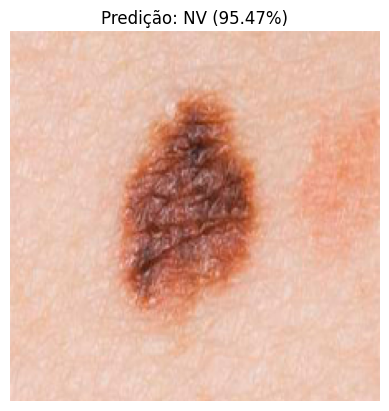


Probabilidades para cada classe:


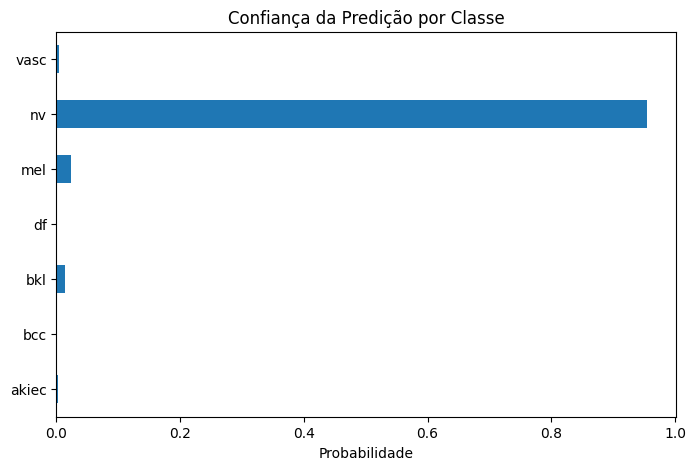

In [16]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.models import load_model

# --- 1. Carregar o Modelo Salvo ---
# Certifique-se de que o modelo está carregado na memória
try:
    best_model_cnn
except NameError:
    print("Carregando o modelo CNN do arquivo...")
    best_model_cnn = load_model('saved_models/cnn_resnet_best.h5')


# --- 2. Dicionário para Mapear Índices para Nomes de Classe ---
# Use o dicionário do seu gerador de treino para garantir consistência
class_labels = {v: k for k, v in train_generator.class_indices.items()}
print("Mapeamento de Classes:", class_labels)


# --- 3. Função de Predição para uma Única Imagem ---
def predict_single_image(model, img_path):
    """Carrega, pré-processa e prevê a classe de uma única imagem."""
    # Carregar a imagem
    img = image.load_img(img_path, target_size=(224, 224)) # Usar o mesmo IMG_SIZE do treino

    # Converter para array e normalizar
    img_array = image.img_to_array(img)
    img_array_normalized = img_array / 255.0

    # Adicionar a dimensão do lote (batch)
    img_batch = np.expand_dims(img_array_normalized, axis=0)

    # Fazer a predição
    prediction_proba = model.predict(img_batch)[0]
    predicted_class_index = np.argmax(prediction_proba)
    predicted_class_name = class_labels[predicted_class_index]
    confidence = prediction_proba[predicted_class_index]

    # Exibir resultados
    plt.imshow(img)
    plt.title(f'Predição: {predicted_class_name.upper()} ({confidence:.2%})')
    plt.axis('off')
    plt.show()

    # Exibir gráfico de probabilidades
    print("\nProbabilidades para cada classe:")
    prob_df = pd.DataFrame(prediction_proba, index=class_labels.values(), columns=['Probabilidade'])
    prob_df.plot(kind='barh', figsize=(8, 5), legend=None)
    plt.xlabel("Probabilidade")
    plt.title("Confiança da Predição por Classe")
    plt.show()

# --- 4. Executar o Upload e a Predição ---
print("\n--- Teste com Imagem Aleatória ---")
print("Por favor, faça o upload de uma imagem de lesão de pele (JPG, PNG).")
uploaded = files.upload()

if uploaded:
    # Pegar o nome do arquivo da primeira imagem enviada
    file_path = list(uploaded.keys())[0]

    # Chamar a função de predição
    predict_single_image(best_model_cnn, file_path)
else:
    print("Nenhum arquivo foi enviado.")

### Análise Final: Diagnóstico por Visão Computacional

Após um processo iterativo de desenvolvimento, chegamos a um modelo de Rede Neural Convolucional (CNN) funcional e com resultados significativos. Esta seção detalha a abordagem final e analisa a performance do modelo.

### Abordagem Final: Fine-Tuning com ResNet50V2

Para a tarefa de classificação de imagens, adotamos uma estratégia de **Transfer Learning** sobre a robusta arquitetura **ResNet50V2**. A metodologia foi desenhada para maximizar o aprendizado e superar os desafios do dataset, como o severo desbalanceamento de classes.

As principais técnicas empregadas foram:
*   **Fine-Tuning Parcial:** Em vez de congelar todo o modelo base, permitimos que a segunda metade de suas camadas se adaptasse aos nossos dados desde o início, acelerando o aprendizado de features específicas para lesões de pele.
*   **Balanceamento por `class_weight`:** Atribuímos pesos inversamente proporcionais à frequência das classes durante o treinamento. Isso força o modelo a dar mais importância aos erros cometidos nas categorias mais raras (como `mel` e `vasc`), evitando o colapso de classe.
*   **Data Augmentation Agressiva:** Aplicamos um conjunto diversificado de transformações (rotações, zoom, flips) nas imagens de treino, criando um dataset mais rico e prevenindo que o modelo memorize os dados de treino (overfitting).
*   **Otimização da Taxa de Aprendizagem:** Utilizamos o callback `ReduceLROnPlateau`, que ajusta dinamicamente a taxa de aprendizado, permitindo uma convergência mais rápida e estável.

### Análise de Performance e Resultados

O histórico de treinamento demonstrou um aprendizado saudável, com as curvas de acurácia e perda evoluindo positivamente tanto para os dados de treino quanto para os de validação conforme vimos pelo **gráfico de Acurácia do Modelo CNN**.

A avaliação final no conjunto de teste revelou a real capacidade do nosso modelo de CNN:

**Métricas Gerais:**
*   **Acurácia Geral:** 69.2%
*   **Acurácia Balanceada:** 48.3%
*   **AUC Ponderada:** 88.4%

A **Acurácia Balanceada de 48.3%** é a métrica mais importante, pois confirma que o modelo aprendeu a generalizar para todas as 7 classes, não se limitando a prever apenas a classe majoritária. Um resultado satisfatório considerando que desde o início da exploração de nossos metadados já havíamos notado este grande problema.

**Principais Insights:**
*   **Detecção de Melanoma (`mel`):** O modelo alcançou um **Recall de 42.2%**, um resultado significativo que prova a viabilidade da análise de imagem para identificar uma porção considerável dos casos mais críticos.
*   **Performance em Outras Classes:** O modelo se destacou na classificação de Carcinoma Basocelular (`bcc`), com um Recall de 75.7%, mostrando sua capacidade de aprender *features* visuais distintas para diferentes tipos de lesões.
*   **Padrões de Confusão:** A matriz de confusão mostra que o modelo, assim como um especialista humano, tende a confundir classes visualmente similares, como Melanoma (`mel`) com Nevos (`nv`) ou outros tipos de câncer (`bcc`), destacando a complexidade inerente ao problema.

### Conclusão: O Poder da Sinergia entre Modelos

A conclusão desta ferramenta de visão computacional é um dos insights mais valiosos do projeto. Ao comparar nossos dois modelos campeões, emergiram papéis claros e complementares:

1.  **O Modelo Tabular (XGBoost) como "Clínico Generalista":** Utilizando o **contexto do paciente** (idade, etc.), este modelo provou ser o pilar da **segurança**, alcançando um impressionante **Recall de 94% para Melanoma**.

2.  **O Modelo de Imagem (CNN) como "Especialista Visual":** Focado nas **características da imagem** (textura, cor, bordas), a CNN atua como uma valiosa "segunda opinião", capaz de identificar 42% dos melanomas e se destacar em outras categorias com base em padrões visuais.

A solução de IA mais poderosa e inovadora para o futuro seria, portanto, um **sistema híbrido (ensemble)** que combine as previsões de ambos os modelos. Tal sistema alavancaria tanto o contexto clínico quanto a análise de imagem, espelhando e potencializando o processo de diagnóstico de um dermatologista especialista. O que seria uma possível solução para o problema de classes que são visualmente similares dando um poder de decisão ainda maior ao profissional de saúde em uma tomada de decisão.